# Get proxy ratings for trails based on ridelogs

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import surprise
import psycopg2
import matplotlib.pyplot as plt
from surprise import Reader,NormalPredictor,accuracy,SVD,Dataset,evaluate,CoClustering,NMF,KNNBasic
from surprise.model_selection import cross_validate,train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from surprise import dump

## ETL

In [2]:
# Query data from SQL database
conn = psycopg2.connect("host=localhost dbname=trailrec user=briangraham")
cur = conn.cursor()
sql_query = """
SELECT trail_id,ride_date,rider_name,rider_url FROM ridelogs;
"""
df = pd.read_sql_query(sql_query,conn)

In [3]:
# get total ride counts
rider_name_list = df['rider_name'].unique()
ridecounts = df.groupby('rider_name')['trail_id'].count()
df_rider_total = pd.DataFrame({'ride_counts':ridecounts})

# get total ride counts by trail
df_rider_trail_counts_group = df.groupby(['rider_name','trail_id'])
df_rider_trail_counts = df_rider_trail_counts_group.count()
df_rider_trail_counts = df_rider_trail_counts[['ride_date']]

# Combine and get rider ratings
df_combined = df_rider_trail_counts.join(df_rider_total,on='rider_name')
df_combined.columns = ['nrides', 'total_rides']

df_combined['ride_fraction'] = df_combined['nrides']/df_combined['total_rides']
#df_combined['ride_freq'] = df_combined['total_rides']/df_combined['ride_fraction']
#plt.hist((df_combined['ride_freq']))
df_combined['log_ride_fraction'] = (np.log(df_combined['ride_fraction']))
#df_combined['log_ride_freq'] = (np.log(df_combined['ride_freq']))
scaler = MinMaxScaler(feature_range=(1, 5), copy=True)
scaler.fit(df_combined[['log_ride_fraction']])
df_combined['scaled_log_ride_fraction'] = scaler.transform(df_combined[['log_ride_fraction']])
#scaler.fit(df_combined[['log_ride_freq']])
#df_combined['scaled_log_ride_freq'] = scaler.transform(df_combined[['log_ride_freq']])
df_combined

nrides  \
rider_name        trail_id                                              
0-austintatious-0 aline-lower                                       3   
                  central-scrutinizer                               1   
                  comfortably-numb-foreplay-descent                 1   
                  crank-it-up-lower                                 1   
                  crank-it-up-upper                                 1   
                  dinah-moe-humm                                    1   
                  drop-in-clinic                                    1   
                  duffman-lower                                     1   
                  duffman-upper                                     1   
                  easy-does-it-lower                                3   
                  easy-does-it-upper                                1   
                  family-cross                                      2   
                  fountain-love                                     1   
                  gypsy-drum                                        1   
                  heart-darkness                                    1   
                  hornet                                            3   
                  i-m-not-satisfied-6729                            2   
                  ms-pinky                                          1   
                  packard-goose                                     2   
                  siwash-trail                                      1   
                  soap-and-old-clothes-6739                         1   
                  tin-pants                                         1   
                  top-world                                         1   
                  valley-trail-day-lots-to-upper-village            1   
                  valley-trail-lost-lake-to-day-lots                1   
                  valley-trail-lost-lake-to-the-upper-village       1   
                  white-gold-traverse                               1   
                  yummy-numby                                       1   
007123            fool-s-gold-9921                                  2   
                  full-nelson                                       3   
...                                                               ...   
zurtak            road-runner                                       1   
                  rock-about                                        2   
                  rock-garden                                       1   
                  rock-n-roll                                       1   
                  rodeo-drive                                       4   
                  selkirk-slacker                                   4   
                  seven-summits                                     1   
                  showdown                                          2   
                  the-dewdney-trail                                 1   
                  training-wheels                                   1   
                  trial--error                                      3   
                  upper-bottoms-65636                               1   
zwiggles          central-scrutinizer                               2   
                  dinah-moe-humm                                    3   
                  dwarf-nebula                                      3   
                  fountain-love                                     3   
                  gee-i-like-your-pants                             2   
                  gypsy-drum                                        3   
                  hooktender                                        1   
                  i-m-not-satisfied-6729                            3   
                  jellyroll-gumdrop                                 2   
                  molly-hogan                                       1   
                  ms-pinky                      

In [8]:
plt.hist(df_combined['ride_fraction'],bins = 20)
plt.title('Distribution of Ride Fractions')
plt.ylabel('Number of Ratings')
plt.xlabel('Rating')
plt.tight_layout()
plt.savefig('graphs/non_normalized_ratings_only.png')

AttributeError: module 'matplotlib.pyplot' has no attribute 'pde'

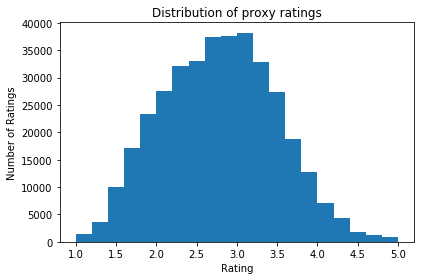

In [8]:
#plt.hist(df_combined['ride_fraction'])
plt.hist(df_combined['scaled_log_ride_fraction'],bins=20)
#plt.legend(['fraction of users total rides','log of fraction (min/max scaled)'])
plt.title('Distribution of proxy ratings')
plt.ylabel('Number of Ratings')
plt.xlabel('Rating')
plt.tight_layout()
plt.savefig('graphs/proxy_ratings_only.png')

# Modeling

In [58]:
# prepare data
df_sub = df_combined
#df_sub =  df_combined[df_combined['total_rides'] > 100] # option to take a subset of users
df_formatted = df_sub.reset_index()
df_formatted.head()

,rider_name,trail_id,nrides,total_rides,ride_fraction,log_ride_fraction,scaled_log_ride_fraction
0,0-austintatious-0,aline-lower,3,37,0.081081,-2.512306,3.830262
1,0-austintatious-0,central-scrutinizer,1,37,0.027027,-3.610918,3.318744
2,0-austintatious-0,comfortably-numb-foreplay-descent,1,37,0.027027,-3.610918,3.318744
3,0-austintatious-0,crank-it-up-lower,1,37,0.027027,-3.610918,3.318744
4,0-austintatious-0,crank-it-up-upper,1,37,0.027027,-3.610918,3.318744


In [69]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_formatted[['rider_name','trail_id','scaled_log_ride_fraction']], reader)

# sample random trainset and testset
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(data, test_size=.20)

# Train and compare models

In [70]:
# Compare algorithms
algo_svd = SVD()                                                       
algo_knn = KNNBasic()
algo_normalpredictor = NormalPredictor()
algo_coclustering = CoClustering()
algo_nmf = NMF()

rmse_all = []

kf = KFold(n_splits=5)
for trainset, testset in kf.split(data): 

    algo_svd.fit(trainset)                             
    predictions_svd = algo_svd.test(testset)

    algo_knn.fit(trainset)
    predictions_knn = algo_knn.test(testset)

    algo_normalpredictor.fit(trainset)
    predictions_normalpredictor = algo_normalpredictor.test(testset)

    algo_coclustering.fit(trainset)
    predictions_coclustering = algo_coclustering.test(testset)

    algo_nmf.fit(trainset)
    predictions_nmf = algo_nmf.test(testset)

    rmse_all.append(accuracy.rmse(predictions_svd))
    rmse_all.append(accuracy.rmse(predictions_knn))
    rmse_all.append(accuracy.rmse(predictions_normalpredictor))
    rmse_all.append(accuracy.rmse(predictions_coclustering))
    rmse_all.append(accuracy.rmse(predictions_nmf))

    #dump.dump('./dump_SVD', predictions_svd, algo_svd)
    #dump.dump('./dump_KNN', predictions_knn, algo_knn)
    #dump.dump('./dump_NormalPredictor', predictions_normalpredictor, algo_normalpredictor)
    #dump.dump('./dump_CoClustering', predictions_coclustering, algo_coclustering)
    #dump.dump('./dump_NMF', predictions_nmf, algo_nmf)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3817
RMSE: 0.4060
RMSE: 0.9977
RMSE: 0.6714
RMSE: 0.3730
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3825
RMSE: 0.4074
RMSE: 1.0017
RMSE: 0.6686
RMSE: 0.3724
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3795
RMSE: 0.4040
RMSE: 0.9950
RMSE: 0.6586
RMSE: 0.3718
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3785
RMSE: 0.4038
RMSE: 0.9957
RMSE: 0.6732
RMSE: 0.3691
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3848
RMSE: 0.4062
RMSE: 1.0002
RMSE: 0.6655
RMSE: 0.3730


In [2]:
predictions_svd,algo_svd = dump.load('./dump_SVD')
predictions_knn,algo_knn = dump.load('./dump_KNN')
predictions_normalpredictor,algo_normalpredictor = dump.load('./dump_NormalPredictor')
predictions_coclustering,algo_coclustering = dump.load('./dump_CoClustering')
predictions_nmf,algo_nmf = dump.load('./dump_NMF')

In [5]:
df_combined.describe()

,nrides,total_rides,ride_fraction,log_ride_fraction,scaled_log_ride_fraction
count,369036.000000,369036.000000,369036.000000,369036.000000,369036.000000
mean,3.432383,531.774800,0.027106,-4.756451,2.785380
std,7.964341,718.647454,0.067807,1.518293,0.706923
min,1.000000,1.000000,0.000186,-8.591001,1.000000
25%,1.000000,73.000000,0.002755,-5.894403,2.255546
50%,1.000000,250.000000,0.008772,-4.736198,2.794810
75%,3.000000,708.000000,0.025000,-3.688879,3.282445
max,563.000000,5383.000000,1.000000,0.000000,5.000000


In [13]:
from collections import defaultdict
def precision_recall_at_k(predictions, k=10, threshold=3.282445):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [14]:
pred_set = [predictions_svd, predictions_knn, predictions_normalpredictor, predictions_coclustering, predictions_nmf]
method = ['SVD','KNN','NormPred','CoClust','NMF']
prec = dict()
rec = dict()
rmse = dict()
for pred, meth in zip(pred_set,method):
    precisions, recalls = precision_recall_at_k(pred, k=10, threshold=4)
    prec[meth] = (sum(prec for prec in precisions.values()) / len(precisions))
    rec[meth] =(sum(rec for rec in recalls.values()) / len(recalls))
    rmse[meth] = accuracy.rmse(pred)

RMSE: 0.3848
RMSE: 0.4062
RMSE: 1.0002
RMSE: 0.6655
RMSE: 0.3730


In [15]:
df_summary = pd.DataFrame.from_dict({'precision':prec,'recall':rec,'rmse':rmse})
df_summary

,precision,recall,rmse
CoClust,0.997470,0.831073,0.665493
KNN,0.998766,0.731809,0.406199
NMF,0.944911,0.873356,0.372976
NormPred,0.751419,0.725926,1.000204
SVD,0.998025,0.714885,0.384844


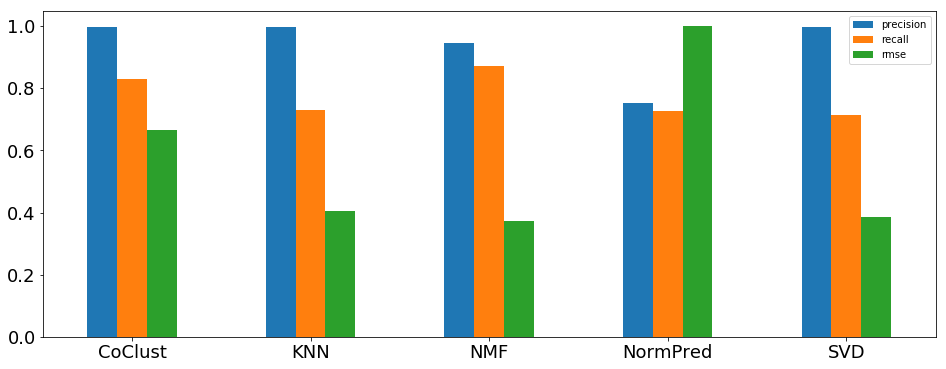

In [16]:
df_summary.plot(kind='bar',figsize=(16,6),fontsize=18,rot=0)

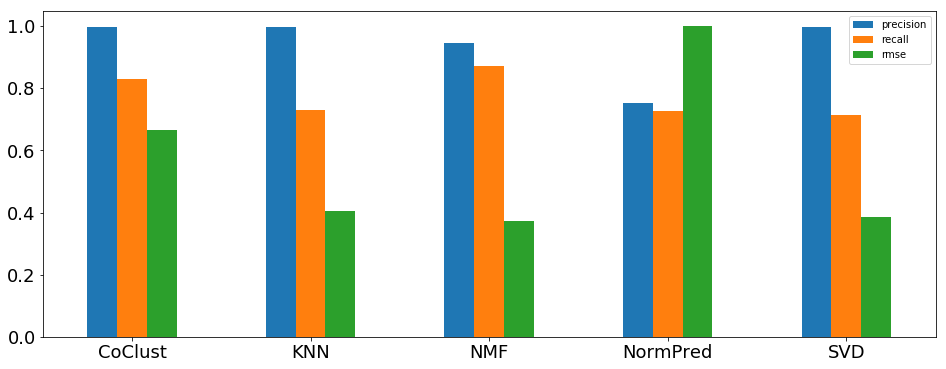

In [12]:
df_summary.plot(kind='bar',figsize=(16,6),fontsize=18,rot=0)

In [13]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n